<a href="https://colab.research.google.com/github/A-wagstaff/CapU-Comp/blob/main/COMP215/Projects/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
from scipy.signal import correlate2d



%matplotlib inline
# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')

# Schelling's Model

Schelling's Model is an agent-based model, which makes it a prime example of cellular automata simulation. The model states that even with mild prefences, segregation of societies will occur. To read more about the math and model, the wikipedia page is fairly helpful. 

https://en.wikipedia.org/wiki/Schelling%27s_model_of_segregation

Taken from *On* *Complexity* Notebook Cell2D.py, found at https://colab.research.google.com/github/A-wagstaff/complex-colab/blob/master/Cell2D_py.ipynb?authuser=1

In [2]:
class Cell2D:
    """Implements Conway's Game of Life."""

    def __init__(self, n, m=None):
        """Initializes the attributes.
        n: number of rows
        m: number of columns
        """
        m = n if m is None else m
        self.array = np.zeros((n, m), np.uint8)

    def add_cells(self, row, col, *strings):
        """Adds cells at the given location.
        row: top row index
        col: left col index
        strings: list of strings of 0s and 1s
        """
        for i, s in enumerate(strings):
            self.array[row+i, col:col+len(s)] = np.array([int(b) for b in s])

    def step(self):
        """Executes one time step."""
        pass
    


Code blocks provided by you from several labs and weekly notebooks. 

In [3]:
DEFAULT_IMSHOW_OPTIONS = dict(
    cmap = 'Blues',
    interpolation='none',
    origin='upper',
)

def plot_2D_array(array, axes=None, title='', **options):
    """ Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue. """
    axes = axes or plt.gca()   # If not axes are provided, draw on current axes
    axes.set_title(title)
    axes.set_xticks([], [])  # remove axes tick marks
    axes.set_yticks([], [])
    options = {**DEFAULT_IMSHOW_OPTIONS, **options}
    axes.imshow(array, **options)

In [4]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number
    """

    def __init__(self, model, frames=50, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            self.model.step()
        self.model.draw(self.ax, step=step)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()          # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)     # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()               # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

In [5]:
def locs_where(condition):
      return list(zip(*np.nonzero(condition)))



Taken from a notebook found at https://colab.research.google.com/github/AllenDowney/ThinkComplexity2/blob/master/soln/chap09.ipynb#scrollTo=jy1scg6mPoVB

I'm going to be honest here, I do not understand these modelling problems well enough to do them on my own. This shows off my "*Google-Fu*" better than it does any programming skills.

However, parts have been modified to use code blocks that you have provided with us to handle the drawing/matplot work. This is fairly complex task of reverse engineering and adapting both sets.

In [12]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# make a custom color map

class Schelling(Cell2D):
    """Represents a grid of Schelling agents."""
    
    options = dict(mode='same', boundary='wrap')

    kernel = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]], dtype=np.int8)
    
    

    
    def __init__(self, n, p):
        """Initializes the attributes.

        n: number of rows
        p: threshold on the fraction of similar neighbors
        """
        self.p = p
        # 0 is empty, 1 is red, 2 is blue
        choices = np.array([0, 1, 2], dtype=np.int8)
        probs = [0.1, 0.45, 0.45]
        self.array = np.random.choice(choices, (n, n), p=probs)

    def count_neighbors(self):
        """Surveys neighboring cells.
        
        returns: tuple of
            empty: True where cells are empty
            frac_red: fraction of red neighbors around each cell
            frac_blue: fraction of blue neighbors around each cell
            frac_same: fraction of neighbors with the same color
        """
        a = self.array
        
        empty = a==0
        red = a==1
        blue = a==2

        # count red neighbors, blue neighbors, and total
        num_red = correlate2d(red, self.kernel, **self.options)
        num_blue = correlate2d(blue, self.kernel, **self.options)
        num_neighbors = num_red + num_blue

        # compute fraction of similar neighbors
        frac_red = num_red / num_neighbors
        frac_blue = num_blue / num_neighbors
        
        # no neighbors is considered the same as no similar neighbors 
        # (this is an arbitrary choice for a rare event)
        frac_red[num_neighbors == 0] = 0
        frac_blue[num_neighbors == 0] = 0
        
        # for each cell, compute the fraction of neighbors with the same color
        frac_same = np.where(red, frac_red, frac_blue)

        # for empty cells, frac_same is NaN
        frac_same[empty] = np.nan
        
        return empty, frac_red, frac_blue, frac_same

    def segregation(self):
        """Computes the average fraction of similar neighbors.
        
        returns: fraction of similar neighbors, averaged over cells
        """
        _, _, _, frac_same = self.count_neighbors()
        return np.nanmean(frac_same)
    
    def step(self):
        """Executes one time step.
                
        returns: fraction of similar neighbors, averaged over cells
        """
        a = self.array
        empty, _, _, frac_same = self.count_neighbors()
        
        # find the unhappy cells (ignore NaN in frac_same)
        with np.errstate(invalid='ignore'):
            unhappy = frac_same < self.p
        unhappy_locs = locs_where(unhappy)
        
        # find the empty cells
        empty_locs = locs_where(empty)

        # shuffle the unhappy cells
        if len(unhappy_locs):
            np.random.shuffle(unhappy_locs)
            
        # for each unhappy cell, choose a random destination
        num_empty = np.sum(empty)
        
        for source in unhappy_locs:
            i = np.random.randint(num_empty)
            dest = empty_locs[i]
            
            # move
            a[dest] = a[source]
            a[source] = 0
            empty_locs[i] = source
        
            # check that the number of empty cells is unchanged
            num_empty2 = np.sum(a==0)
            assert num_empty == num_empty2
        
        # return the average fraction of similar neighbors
        return np.nanmean(frac_same)
        
    def draw(self, axes=None, step=''):
        """Differs from the draw function in the notebook it cames from,
         as it has been adapted to work with code blocks supplied by you"""
        axes = axes or plt.gca()   # use pyplot's current axes if none are provided.
        plot_2D_array(self.array, axes, title=f"Schelling's Model {step}")

0.49618001046572474

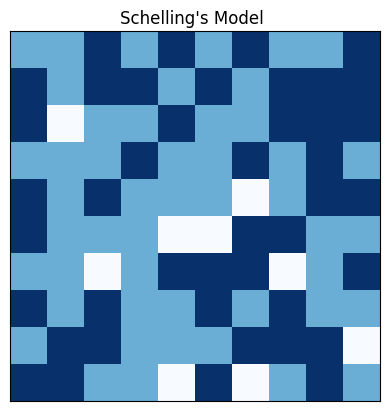

In [7]:
grid = Schelling(n=10, p=0.3)
grid.draw()
grid.segregation()

In [8]:
grid = Schelling(n=50,p=0.4)
ani = Animation2D(grid, frames=20)
ani.show()


0.5059198892084797


This animation visualizes the speed in which the model works. At preferences around 30%, the segregation that the model simulates happens quickly, reaching a steady state in only a handful of steps. At high prefences, the system stays in chaos almost indefininetly, as there is not enough space to completely segregate the system. The above animation is with a preference of 40%, while the animation below is with a preference of 75%.

In [15]:
grid = Schelling(n=50,p=0.75)
ani = Animation2D(grid, frames=20)
ani.show()


In [9]:
# Functions retrieved from https://raw.githubusercontent.com/AllenDowney/ThinkComplexity2/master/notebooks/utils.py. 
# Not all functions in this file are important, so most were ignored. 
# The main one is the decorate function, and underride and legend are support for it.

def underride(d, **options):
    """Add key-value pairs to d only if key is not in d.

    d: dictionary
    options: keyword args to add to d
    """
    for key, val in options.items():
        d.setdefault(key, val)

    return d
def legend(**options):
    """Draws a legend only if there is at least one labeled item.

    options are passed to plt.legend()
    https://matplotlib.org/api/_as_gen/matplotlib.pyplot.legend.html

    """
    underride(options, loc="best", frameon=False)

    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels, **options)

def decorate(**options):
    """Decorate the current axes.

    Call decorate with keyword arguments like

    decorate(title='Title',
             xlabel='x',
             ylabel='y')

    The keyword arguments can be any of the axis properties

    https://matplotlib.org/api/axes_api.html

    In addition, you can use `legend=False` to suppress the legend.

    And you can use `loc` to indicate the location of the legend
    (the default value is 'best')
    """
    loc = options.pop("loc", "best")
    if options.pop("legend", True):
        legend(loc=loc)

    plt.gca().set(**options)
    plt.tight_layout()

0.9 0.5063971378786193 -0.39360286212138074
0.7 0.7304727294823833 0.03047272948238333
0.6 0.8863172077199454 0.2863172077199454
0.5 0.8642387305116598 0.3642387305116598
0.4 0.8213376792007844 0.42133767920078435
0.3 0.7519954245043212 0.45199542450432123
0.2 0.5694329755023396 0.3694329755023396
0.1 0.508127632364676 0.408127632364676


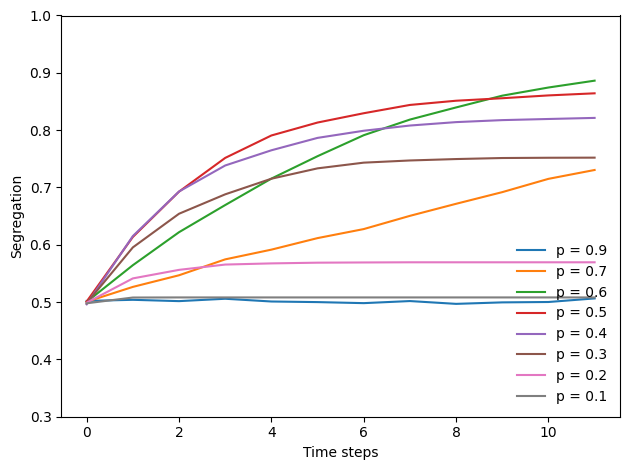

In [14]:
# Once again, taken from https://colab.research.google.com/github/AllenDowney/ThinkComplexity2/blob/master/soln/chap09.ipynb#scrollTo=66AgbKrYPoU0
for p in [0.9,0.7,0.6,0.5,0.4,0.3,0.2,0.1]:
    grid = Schelling(n=100, p=p)
    segs = [grid.step() for i in range(12)]
    plt.plot(segs, label='p = %.1f' % p)
    print(p, segs[-1], segs[-1] - p)
    
decorate(xlabel='Time steps', ylabel='Segregation',
                loc='lower right', ylim=[0.3, 1])


As this graph shows, the more 'prejudiced' a community is, the longer it takes for the community to reach a steady level of happiness. The extreme values, such as p=0.9 for instance, actually desegregate slightly, where as low values such as p=0.2 segregation increases rapidly but reaches a steady state in a rapid manner. 


#Conclusion
While this model works as a rudimentary method of displaying segregation, it does not allow for several factors that play into real world examples of segregation. 

It does show that even if a small percentage of a population wish for segregation, it will happen to differing extremes. 

Schellings Model does not account for several real world factors such as forceful removal from neighbourhoods, which is common in real world examples.